In [1]:
# imports usuels

import numpy as np
import matplotlib.pyplot as plt
import time

from ipywidgets import interact

# fonctions de scikit-learn

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# recherche de paramètres

from sklearn.model_selection import GridSearchCV
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV

# régression et mesure d'erreur

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# génération et jeux de données

from sklearn.datasets import make_moons
from sklearn.datasets import make_regression
from sklearn.datasets import load_wine
from sklearn.datasets import load_diabetes

# trace des exemples (complètement manufacturés) de SVM non-linéaire en 2D et 3D

import numpy.random as rand
from matplotlib.lines import Line2D 
from mpl_toolkits.mplot3d import Axes3D

def plot_SVM_3D():
    fig = plt.figure(figsize=(22, 6))
    
    # cas linéaire

    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('cas linéaire')
    
    ax.add_line(Line2D([0, 0], [0, 1], color='k', linewidth=2))
    
    x = 0.2 + 0.8 * rand.random(100)
    y = rand.random(100)
    
    ax.scatter(x, y)
    
    x2 = (0.2 + 0.8 * rand.random(100)) - 1.2
    y2 = rand.random(100)
    
    ax.scatter(x2, y2)
    
    # cas non-linéaire 2D

    ax = fig.add_subplot(1, 3, 2)
    ax.set_title('cas non-linéaire')
    
    ax.set_aspect('equal', 'box')

    t = np.linspace(0, 2*np.pi, 100)
    ax.plot(np.cos(t), np.sin(t), color='k', linewidth=2)

    r = 0.8 * rand.random(100)
    theta = 2*np.pi * rand.random(100)

    ax.scatter(r*np.cos(theta), r*np.sin(theta));

    r2 = 1.2 + 0.8 * rand.random(100)
    theta2 = 2*np.pi * rand.random(100)

    ax.scatter(r2*np.cos(theta2), r2*np.sin(theta2));
    
    # cas non-linéaire 3D

    ax = fig.add_subplot(1, 3, 3, projection='3d')
    ax.set_title('cas non-linéaire : projection 3D')
    
    ax.view_init(10, 60)
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 2, 1]))

    z = r**2 - 0.8
    ax.scatter(r*np.cos(theta), r*np.sin(theta), z)

    z2 = (r2 - 1)**2
    ax.scatter(r2*np.cos(theta2), r2*np.sin(theta2), z2)

    xx = np.linspace(-2, 2, 50)
    xx, yy = np.meshgrid(xx, xx)
    ax.plot_surface(xx, yy, 0*xx, alpha=0.2)
    ax.plot(np.cos(t), np.sin(t), 0, color='k', linewidth=2)

# trace un exemple de régression linéaire

def plot_example_regression(n_samples=100):
    fig = plt.figure(figsize=(22, 6))
    
    X, y = make_regression(n_samples=n_samples, n_features=1, noise=10, random_state=42)

    ax = fig.add_subplot(1, 2, 1)
    ax.set_title('nuage de points')
    
    ax.scatter(X, y, color='black')
    
    regr = linear_model.LinearRegression(normalize=True) 

    regr.fit(X, y)   
    y_pred = regr.predict(X)

    ax = fig.add_subplot(1, 2, 2)
    ax.set_title('droite de régression')
    
    ax.scatter(X, y, color='black')
    ax.plot(X, y_pred, color='blue')    

# trace un jeu de données avec une cible binaire

def plot_dataset3(X, y, ax = plt, title=None):
    ax.scatter(X[y == 0, 0], X[y == 0, 1], color='red')
    ax.scatter(X[y == 1, 0], X[y == 1, 1], color='blue')
    if title is not None:
        ax.set_title(title);

# trace les prédictions de la classification

def plot_predictions(X, y_pred, y_decision, svc, ax = plt, score = None, noise = None, degree = None, C = None, gamma = None, title = None):
    # y_pred and y_decision are dummy arguments
    x0s = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
    x1s = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = svc.predict(X).reshape(x0.shape)
    y_decision = svc.decision_function(X).reshape(x0.shape)
    ax.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.25)
    ax.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.2)
    
    if title is not None:
        title = ''
        if noise is not None:
            title += f'noise = {noise}'
        if degree is not None:
            title += f'degree = {degree}'
        if C is not None:
            title += f'C = {C}'
        if gamma is not None:
            title += f'$\gamma$ = {gamma}'
        if ax == plt:
            ax.title(title)
        else:
            ax.set_title(title)            

# affiche le résultat d'une recherche de paramètres

def print_report(clf, noise=None):
    string = ''
    params = clf.best_params_
    best_result = clf.cv_results_['rank_test_score'] == 1
    best_score = clf.cv_results_['mean_test_score'][best_result][0]
    
    if noise is not None:
        string += f'noise = {noise:4.2f}, '
        
    if params['estimator__kernel'] == 'rbf':
        string += r'kernel : rbf  ; C = {0:5.2f} ; γ = {1:5.2f}'.format(params['estimator__C'], params['estimator__gamma'])
    elif params['estimator__kernel'] == 'poly':
        try:
            string += r'kernel : poly ; C = {0:5.2f} ; γ = {1:5.2f} ; r = {2:4.3f} ; d = {3}'.format(params['estimator__C'], params['estimator__gamma'], params['estimator__coef0'], params['estimator__degree'])
        except KeyError:
            string += r'kernel : poly ; C = {0:5.2f} ; r = {1:5.2f} ; d = {2}'.format(params['estimator__C'], params['estimator__coef0'], params['estimator__degree'])
            
    string += f' ; score = {best_score:5.3f}'
    print(string)
    
# affiche et trace le résultat d'une régression

def report_regression(X_train, X_test, y_train, y_test, y_pred, regr, ax=plt, coeffs=False, small=False, title=None, plot=True, string=''):
    
    if plot: 
        # tracé des graphes
        ax.scatter(X_train, y_train, color='black')
        ax.scatter(X_test, y_test, color='red')
        ax.plot(X_test, y_pred, color='blue', linewidth=3)

        fig = plt.gcf()
        if small:
            # plus petite figure pour que ça passe sur la slide...
            fig.set_size_inches(10, 2)
        else:
            if ax == plt:
                fig.set_size_inches(10, 4)

        if title is not None:
            if ax == plt:
                plt.title(title)
            else:
                ax.set_title(title)
    
    # alpha et l1ratio
    try:
        string += f"alpha = {regr.alpha_:5.3e}, "
    except AttributeError:
        pass
    try:
        string += f"l1_ratio = {regr.l1_ratio_:4.3f}, "
    except AttributeError:
        pass
    # erreur quadratique
    string += f"Erreur quadratique: {mean_squared_error(y_test, y_pred):5.3f}, "
    # coefficient de détermination
    string += f"Coefficient de détermination: {r2_score(y_test, y_pred):5.3f}"
        
    print(string)
    
    if coeffs:
        print(f"Coefficients de la droite: {regr.intercept_}, {regr.coef_}")
        
# récupère données/cibles d'entraînement et de test

def get_train_test(X, y, ratio=10):
    
    n_samples = np.shape(X)[0]

    np.random.seed(42)
    random_range = np.random.randint(0, n_samples, n_samples // ratio)  # ratio% des données seront gardées pour le test

    X_train = np.delete(X, random_range, axis=0)  # données d'entraînement
    X_test = X[random_range]                      # données de test

    y_train = np.delete(y, random_range)  # cibles d'entraînement
    y_test = y[random_range]              # cibles de test
    
    return X_train, X_test, y_train, y_test

# Introduction à sklearn

`scikit-learn` : bibliothèque Python dédiée à l'apprentissage automatique, avec des algorithmes de classification, régression, clustering, ...

### 1) Génération et récupération de données

### 2) Classification (SVM)

### 3) Régression linéaire

## 1) Génération et récupération de données

### Données générées aléatoirement : classification

In [2]:
from sklearn.datasets import make_moons

@interact(noise=(0.0, 0.5, 0.025))
def moons(noise=0.):
    X, y = make_moons(noise=noise)
    plot_dataset3(X, y)

interactive(children=(FloatSlider(value=0.0, description='noise', max=0.5, step=0.025), Output()), _dom_classe…

### Données générées aléatoirement : régression

In [3]:
from sklearn.datasets import make_regression

@interact(noise=(0.0, 100.0, 2.5))
def regression_dataset(noise=0.):
    X, y = make_regression(n_samples=100, n_features=1, noise=noise)
    plt.scatter(X, y);

interactive(children=(FloatSlider(value=0.0, description='noise', step=2.5), Output()), _dom_classes=('widget-…

### Jeux de données : classification

In [4]:
from sklearn.datasets import load_wine

data = load_wine()
[feature for feature in data.feature_names]

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

### Jeux de données : classification

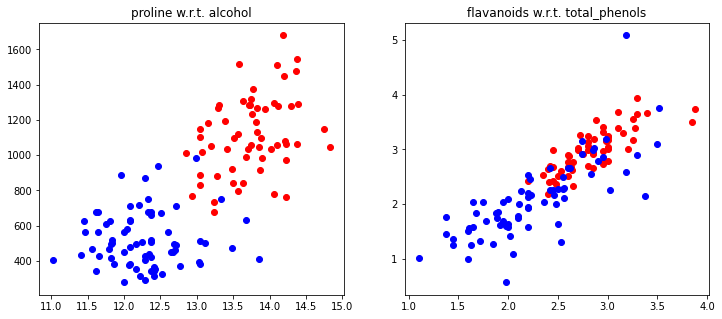

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

for i, features in enumerate([[0, 12], [5, 6]]):
    X = data.data[:, features]
    y = data.target    
    plot_dataset3(X, y, ax[i])
    ax[i].set_title(f'{data.feature_names[features[1]]} w.r.t. {data.feature_names[features[0]]}')

### Jeux de données : régression

In [6]:
from sklearn.datasets import load_diabetes

data = load_diabetes()
for feature in data.feature_names:
    print(feature)

age
sex
bmi
bp
s1
s2
s3
s4
s5
s6


### Jeux de données : régression

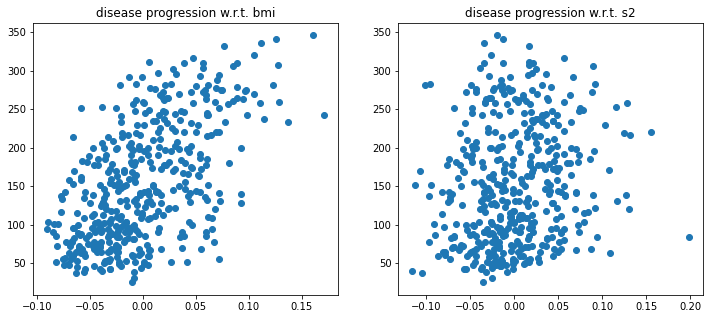

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

for i, k in enumerate([2, 5]):
    X = data.data[:, k]
    y = data.target
    ax[i].scatter(X, y)
    ax[i].set_title(f'disease progression w.r.t. {data.feature_names[k]}')

## 2) Classification (SVM)

**Principe** : construire un hyperplan qui sépare les données, tout en restant le plus loin possible de celles-ci

**Cas des données non linéairement séparables** : considérer le problème en dimension supérieure, où il pourra exister un hyperplan

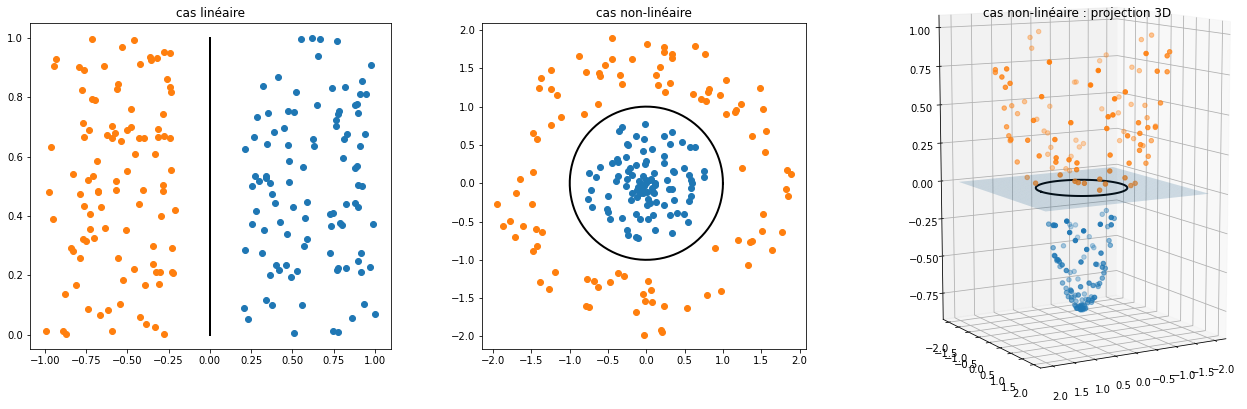

In [8]:
plot_SVM_3D()

### Utilisation de la SVM non-linéaire : choix du noyau (voir exposé de Laurent)

Le noyau est une fonction $k$ qui associe, à chaque couple d'observations $(x,x')$, une mesure de leur «influence réciproque» calculée à travers leur corrélation ou leur distance.

Les noyaux suivants (parmi d'autres) sont implémentés dans `scikit-learn` :
* noyau gaussien : $k(x,x') = \exp(- \gamma \| x - x' \|^2)$   `kernel='rbf'` (par défaut)
* noyau polynomial : $k(x,x') = (\gamma \langle x, x' \rangle + r)^d$   `kernel='poly'`

### Utilisation de la SVM non-linéaire : choix des paramètres du noyau

#### Paramètres communs : $C$ et $\gamma$

* paramètre de régularisation $C$ : plus $C$ est grand, plus la marge d'erreur de la SVM est petite, ce qui entraîne une surface moins régulière
* paramètre d'influence $\gamma$ : plus $\gamma$ est grand, plus l'influence d'une donnée sur ses voisines est petite

#### Paramètres du noyau polynomial :

* degré $d$ : `degree=d`
* valeur à l'origine $r$ : `coef0=r`

Fonction pour la SVM : SVC (support vector classification) 

In [9]:
from sklearn.svm import SVC

Rescaling des données : moyenne nulle et variance égale à $1$

In [10]:
from sklearn.preprocessing import StandardScaler

Pour appliquer des transformations aux données (notamment, un rescaling) avant leur estimation finale 

In [11]:
from sklearn.pipeline import Pipeline

### Noyau gaussien, influence du bruit

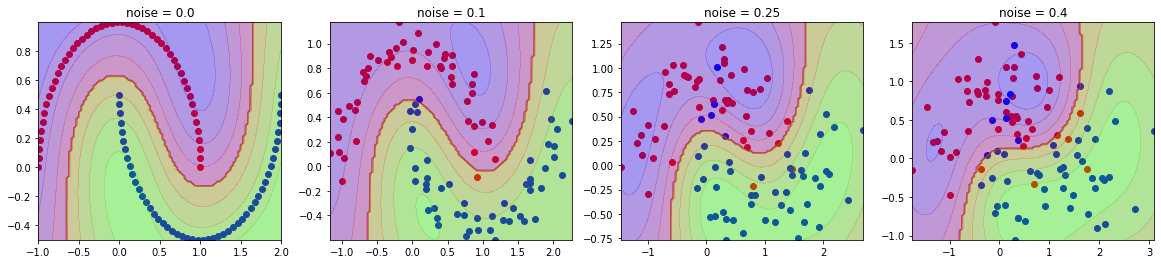

In [52]:
fig, ax = plt.subplots(1, 4, figsize=(20,4))

for i, noise in enumerate([0., 0.1, 0.25, 0.4]):
    X, y = make_moons(noise=noise, random_state=42)

    plot_dataset3(X, y, ax[i])
    
    svc = SVC()     # initialisation de la SVM avec un noyau gaussien (par défaut)
    svc.fit(X, y)   # utilisation des données pour ajuster la SVM

    y_pred = svc.predict(X)                # retourne la prédiction de la SVM (classification binaire des données)
    y_decision = svc.decision_function(X)  # retourne la distance à l'hyperplan
    
    plot_predictions(X, y_pred, y_decision, svc, ax[i], noise=noise, title=True)

### Noyau gaussien, influence de $C$

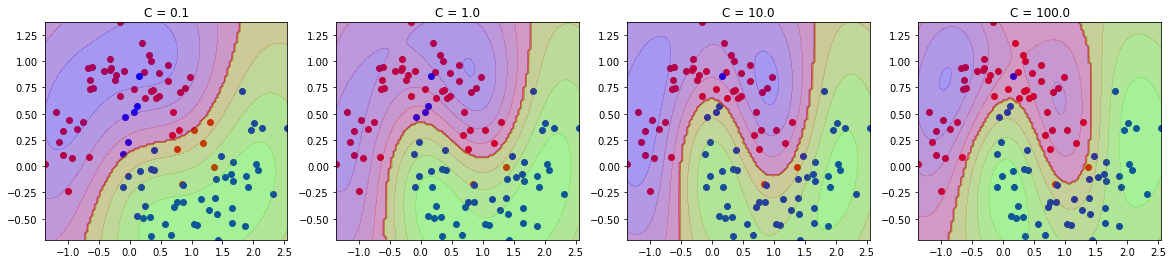

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(20,4))

for i, C in enumerate([1e-1, 1e0, 1e1, 1e2]):
    X, y = make_moons(noise=0.2, random_state=42)

    plot_dataset3(X, y, ax[i])
    
    svc = SVC(kernel='rbf', C=C)
    svc.fit(X, y)

    y_pred = svc.predict(X)
    y_decision = svc.decision_function(X)
    
    plot_predictions(X, y_pred, y_decision, svc, ax[i], C=C, title=True)

### Noyau gaussien, influence de $\gamma$

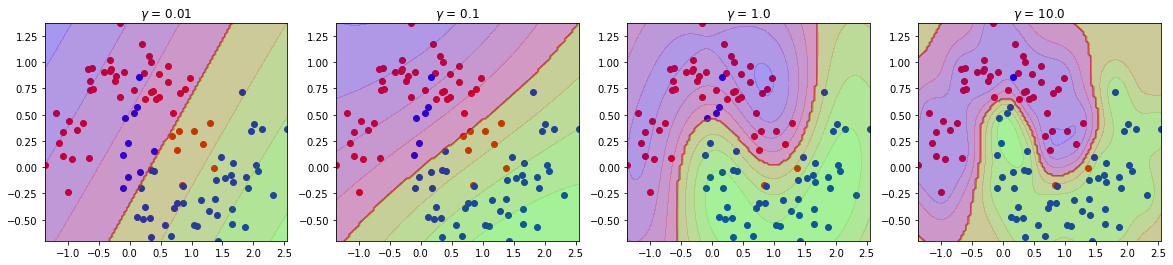

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(20,4))

for i, gamma in enumerate([1e-2, 1e-1, 1e0, 1e1]):
    X, y = make_moons(noise=0.2, random_state=42)

    plot_dataset3(X, y, ax[i])
    
    svc = SVC(kernel='rbf', gamma=gamma)
    svc.fit(X, y)

    y_pred = svc.predict(X)
    y_decision = svc.decision_function(X)
    
    plot_predictions(X, y_pred, y_decision, svc, ax[i], gamma=gamma, title=True)

### Noyau polynomial, influence du degré

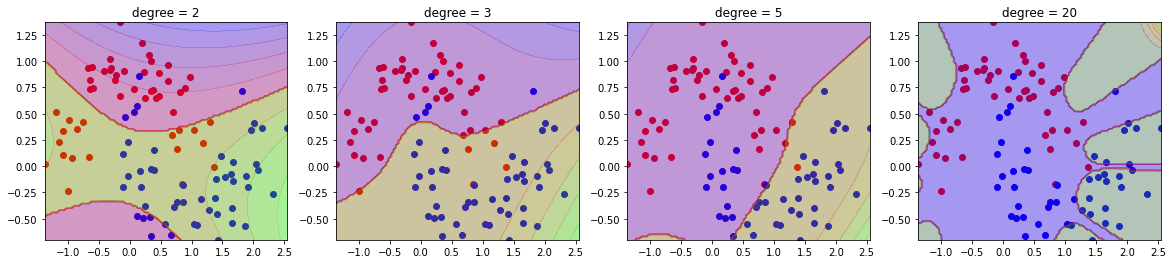

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(20,4))

for i, degree in enumerate([2, 3, 5, 20]):
    X, y = make_moons(noise=0.2, random_state=42)

    plot_dataset3(X, y, ax[i])
    
    svc = SVC(kernel='poly', degree=degree)
    svc.fit(X, y)

    y_pred = svc.predict(X)
    y_decision = svc.decision_function(X)
    
    plot_predictions(X, y_pred, y_decision, svc, ax[i], degree=degree, title=True)

### Noyau polynomial, influence du degré avec une valeur à l'origine non nulle

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(20,4))

for i, degree in enumerate([2, 3, 5, 20]):
    X, y = make_moons(noise=0.2, random_state=42)

    plot_dataset3(X, y, ax[i])
    
    svc = SVC(kernel='poly', degree=degree, coef0=1.)
    svc.fit(X, y)
    
    y_pred = svc.predict(X)
    y_decision = svc.decision_function(X)
    plot_predictions(X, y_pred, y_decision, svc, ax[i], degree=degree, title=True)

### Noyau polynomial, influence du degré après rescaling

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(20,4))

for i, degree in enumerate([2, 3, 5, 20]):
    X, y = make_moons(noise=0.2, random_state=42)

    plot_dataset3(X, y, ax[i])
    
    svc = Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', SVC(kernel='poly', degree=degree, coef0=1.))
    ])
    svc.fit(X, y)

    y_pred = svc.predict(X)
    y_decision = svc.decision_function(X)
    plot_predictions(X, y_pred, y_decision, svc, ax[i], degree=degree, title=True)

### Recherche des paramètres optimaux avec validation croisée : par quadrillage

In [18]:
from sklearn.model_selection import GridSearchCV

parameters = [
    {
        'estimator__kernel': ['rbf'],
        'estimator__C': np.logspace(-2, 2, 9),
        'estimator__gamma': np.logspace(-2, 2, 5),
    },
    {
        'estimator__kernel': ['poly'],
        'estimator__C': np.logspace(-2, 2, 9),
        'estimator__degree': [2, 3, 4, 5],
        'estimator__coef0': np.linspace(-1, 1, 5),
        # 'estimator__gamma': np.logspace(-2, 2, 5),
    }
]

noise = 0.10, kernel : rbf  ; C =  1.00 ; γ = 10.00 ; score = 1.000
noise = 0.15, kernel : poly ; C = 31.62 ; r =  0.50 ; d = 3 ; score = 0.990
noise = 0.25, kernel : rbf  ; C =  3.16 ; γ =  1.00 ; score = 0.950
noise = 0.40, kernel : poly ; C =  3.16 ; r =  1.00 ; d = 4 ; score = 0.860
Wall time: 13.8 s


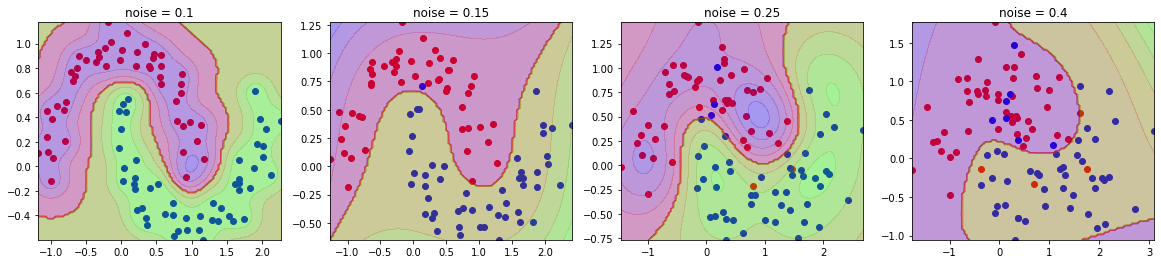

In [19]:
%%time
fig, ax = plt.subplots(1, 4, figsize=(20, 4))

for i, noise in enumerate([0.1, 0.15, 0.25, 0.4]):
    X, y = make_moons(noise=noise, random_state=42)
    plot_dataset3(X, y, ax[i])

    svc = Pipeline([('scaler', StandardScaler()), ('estimator', SVC())])
    clf = GridSearchCV(svc, parameters)  # recherche par quadrillage dans l'espace des paramètres défini par parameters
    clf.fit(X, y)                        # ajustement de la SVM
    print_report(clf, noise=noise)       # affichage des paramètres

    svc = clf.best_estimator_   # sélection du meilleur estimateur trouvé lors de la recherche
    y_pred = svc.predict(X)
    y_decision = svc.decision_function(X)

    plot_predictions(X, y_pred, y_decision, svc, ax[i], noise=noise, title=True)

### Recherche des paramètres optimaux avec validation croisée : aléatoirement

In [20]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

parameters = [
    {
        'estimator__kernel': ['rbf'],
        'estimator__C': stats.loguniform(1e-2, 1e2),
        'estimator__gamma': stats.loguniform(1e-2, 1e2),
        'estimator__class_weight':['balanced', None]
    },
    {
        'estimator__kernel': ['poly'],
        'estimator__C': stats.loguniform(1e-2, 1e2),
        'estimator__degree': stats.randint(2, 8),
        'estimator__coef0': stats.uniform(-1, 1),
        'estimator__gamma': stats.loguniform(1e-2, 1e2),
        'estimator__class_weight':['balanced', None]
    }
]

noise = 0.10, kernel : rbf  ; C = 15.35 ; γ =  8.47 ; score = 1.000
noise = 0.15, kernel : rbf  ; C = 88.62 ; γ =  0.38 ; score = 0.980
noise = 0.25, kernel : rbf  ; C =  0.69 ; γ =  2.54 ; score = 0.920
noise = 0.40, kernel : rbf  ; C = 69.93 ; γ =  0.36 ; score = 0.860
Wall time: 2.75 s


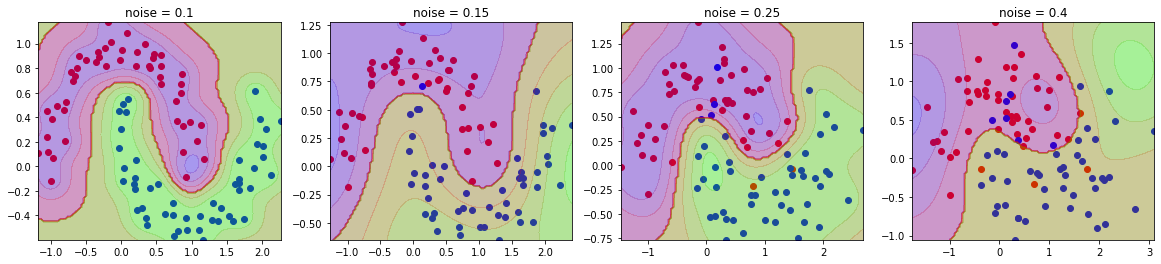

In [21]:
%%time
fig, ax = plt.subplots(1, 4, figsize=(20, 4))

for i, noise in enumerate([0.1, 0.15, 0.25, 0.4]):
    X, y = make_moons(noise=noise, random_state=42)
    plot_dataset3(X, y, ax[i])

    svc = Pipeline([('scaler', StandardScaler()), ('estimator', SVC())])
    clf = RandomizedSearchCV(svc, parameters, n_iter=20, random_state=42)  # recherche aléatoire définie par parameters
    clf.fit(X, y)                                                          # ajustement de la SVM
    print_report(clf, noise=noise)

    svc = clf.best_estimator_   # sélection du meilleur estimateur trouvé lors de la recherche
    y_pred = svc.predict(X)
    y_decision = svc.decision_function(X)

    plot_predictions(X, y_pred, y_decision, svc, ax[i], noise=noise, title=True)

### Recherche des paramètres optimaux : par quadrillage, par dichotomie (expérimental)

In [22]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

parameters = [
    {
        'estimator__kernel': ['rbf'],
        'estimator__C': np.logspace(-2, 2, 9),
        'estimator__gamma': np.logspace(-2, 2, 5),
    },
    {
        'estimator__kernel': ['poly'],
        'estimator__C': np.logspace(-2, 2, 9),
        'estimator__degree': [2, 3, 4, 5],
        'estimator__coef0': np.linspace(-1, 1, 5),
        # 'estimator__gamma': np.logspace(-2, 2, 5),
    }
]

In [23]:
%%time
fig, ax = plt.subplots(1, 4, figsize=(20,4))

for i, noise in enumerate([0.1, 0.15, 0.25, 0.4]):
    X, y = make_moons(noise=noise, random_state=42)

    plot_dataset3(X, y, ax[i])

    svc = Pipeline([('scaler', StandardScaler()), ('estimator', SVC())])

    clf = HalvingGridSearchCV(svc, parameters)  # recherche aléatoire par dichotomie
    clf.fit(X, y)                               # ajustement de la SVM
    print_report(clf, noise=noise)

    svc = clf.best_estimator_   # sélection du meilleur estimateur trouvé lors de la recherche
    y_pred = svc.predict(X)
    y_decision = svc.decision_function(X)

    plot_predictions(X, y_pred, y_decision, svc, ax[i], noise=noise, title=True)

noise = 0.10, kernel : rbf  ; C =  3.16 ; γ =  1.00 ; score = 1.000
noise = 0.15, kernel : poly ; C = 10.00 ; r =  1.00 ; d = 4 ; score = 0.950
noise = 0.25, kernel : poly ; C =  1.00 ; r =  1.00 ; d = 5 ; score = 0.917
noise = 0.40, kernel : poly ; C = 31.62 ; r =  1.00 ; d = 2 ; score = 0.833
Wall time: 20.3 s


### Recherche des paramètres optimaux : aléatoirement, par dichotomie (expérimental)

In [24]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

parameters = [
    {
        'estimator__kernel': ['rbf'],
        'estimator__C': stats.loguniform(1e-2, 1e2),
        'estimator__gamma': stats.loguniform(1e-2, 1e2),
        'estimator__class_weight':['balanced', None]
    },
    {
        'estimator__kernel': ['poly'],
        'estimator__C': stats.loguniform(1e-2, 1e2),
        'estimator__degree': stats.randint(2, 8),
        'estimator__coef0': stats.uniform(-1, 1),
        'estimator__gamma': stats.loguniform(1e-2, 1e2),
        'estimator__class_weight':['balanced', None]
    }
]

noise = 0.10, kernel : rbf  ; C = 69.93 ; γ =  0.36 ; score = 1.000
noise = 0.15, kernel : rbf  ; C = 75.57 ; γ =  0.63 ; score = 0.983
noise = 0.25, kernel : rbf  ; C = 69.93 ; γ =  0.36 ; score = 0.967
noise = 0.40, kernel : poly ; C =  0.29 ; γ =  0.06 ; r = -0.909 ; d = 7 ; score = 0.867
Wall time: 2.29 s


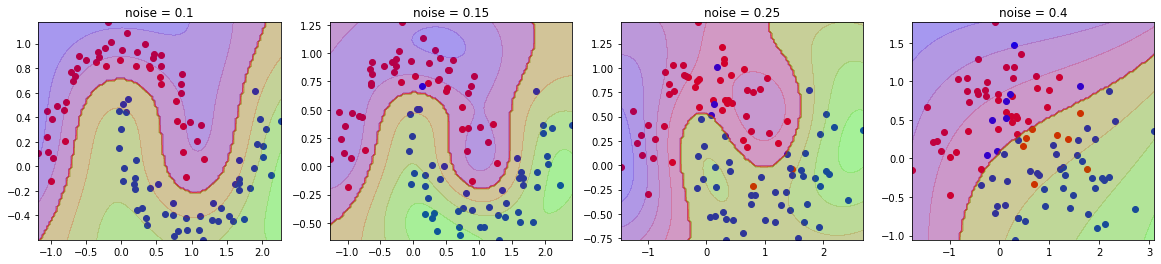

In [25]:
%%time
fig, ax = plt.subplots(1, 4, figsize=(20,4))

for i, noise in enumerate([0.1, 0.15, 0.25, 0.4]):
    X, y = make_moons(noise=noise, random_state=42)
    plot_dataset3(X, y, ax[i])

    svc = Pipeline([('scaler', StandardScaler()), ('estimator', SVC())])
    clf = HalvingRandomSearchCV(svc, parameters, n_candidates=20, random_state=42)  # recherche aléatoire par dichotomie
    clf.fit(X, y)                                                                   # ajustement de la SVM
    print_report(clf, noise=noise)

    svc = clf.best_estimator_   # sélection du meilleur estimateur trouvé lors de la recherche
    y_pred = svc.predict(X)
    y_decision = svc.decision_function(X)

    plot_predictions(X, y_pred, y_decision, svc, ax[i], noise=noise, title=True)

### Application à un jeu de données : classification de vin

In [26]:
from sklearn.datasets import load_wine

data = load_wine()         # chargement du jeu de données

X_full = data.data         # récupération des données
y = data.target            # récupération de la cible : on a trois types de vin (0, 1 et 2)

X_full = X_full[y != 2]    # on ne considère que les types 0 et 1 dans les données
y = y[y != 2]              # on ne considère que les types 0 et 1 dans la cible

### Recherche des paramètres optimaux : par quadrillage

In [27]:
from sklearn.model_selection import GridSearchCV

parameters = [
    {
        'estimator__C': np.logspace(-2, 2, 11),
        'estimator__gamma': np.logspace(-3, 3, 7),
        'estimator__kernel': ['rbf']
    },
    {
        'estimator__C': np.logspace(-2, 2, 11),
        'estimator__degree': np.arange(1, 10),
        'estimator__coef0': np.linspace(-2, 2, 9),
        'estimator__kernel': ['poly']
    }
]

In [28]:
%%time
fig, ax = plt.subplots(1, 3, figsize=(20,4))

for i, features in enumerate([[0, 12], [8, 9], [5, 6]]):
    X = X_full[:, features]
    plot_dataset3(X, y, ax=ax[i], title=f'{data.feature_names[features[1]]} w.r.t. {data.feature_names[features[0]]}')

    svc = Pipeline([('scaler', StandardScaler()), ('estimator', SVC())])
    clf = GridSearchCV(svc, parameters)
    clf.fit(X, y)
    print_report(clf)

    svc = clf.best_estimator_
    y_pred = svc.predict(X)
    y_decision = svc.decision_function(X)

    plot_predictions(X, y_pred, y_decision, svc, ax[i])

kernel : rbf  ; C = 39.81 ; γ =  1.00 ; score = 0.977
kernel : poly ; C =  0.01 ; r =  2.00 ; d = 8 ; score = 0.908
kernel : rbf  ; C =  2.51 ; γ = 10.00 ; score = 0.854
Wall time: 3min 19s


### Recherche des paramètres optimaux : aléatoirement

In [29]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

parameters = [
    {
        'estimator__kernel': ['rbf'],
        'estimator__C': stats.loguniform(1e-0, 1e2),
        'estimator__gamma': stats.loguniform(1e-0, 1e2),
        'estimator__class_weight':['balanced', None]
    },
    {
        'estimator__kernel': ['poly'],
        'estimator__C': stats.loguniform(1e-2, 1e2),
        'estimator__degree': stats.randint(1, 10),
        'estimator__coef0': stats.uniform(-2, 2),
        'estimator__gamma': stats.loguniform(1e-2, 1e2),
        'estimator__class_weight':['balanced', None]
    }
]

In [30]:
%%time
fig, ax = plt.subplots(1, 3, figsize=(20,4))

for i, features in enumerate([[0, 12], [8, 9], [5, 6]]):
    X = X_full[:, features]
    plot_dataset3(X, y, ax=ax[i], title=f'{data.feature_names[features[1]]} w.r.t. {data.feature_names[features[0]]}')

    svc = Pipeline([('scaler', StandardScaler()), ('estimator', SVC())])
    clf = RandomizedSearchCV(svc, parameters, n_iter=20, random_state=29)
    clf.fit(X, y)
    print_report(clf)

    svc = clf.best_estimator_
    y_pred = svc.predict(X)
    y_decision = svc.decision_function(X)

    plot_predictions(X, y_pred, y_decision, svc, ax[i])

kernel : rbf  ; C = 13.62 ; γ =  1.22 ; score = 0.977
kernel : rbf  ; C = 16.65 ; γ =  1.12 ; score = 0.900
kernel : rbf  ; C =  5.86 ; γ =  6.71 ; score = 0.869
Wall time: 1.83 s


## 3) Régression linéaire (voir exposés de Romane et d'Emmanuel)

**Principe** : construire une droite passant au plus près d'un nuage de points

In [32]:
plot_example_regression(n_samples=100)

Bibliothèque pour les différents modèles linéaires :

In [33]:
from sklearn import linear_model

Mesure de l'erreur quadratique $\text{MSE} = \frac 1 n \sum (y_i - \hat y_i)^2$ entre la prédiction $\hat y_i$ et les données $y_i$ :

In [34]:
from sklearn.metrics import mean_squared_error

Mesure du coefficient de détermination $R^2 = 1 - \displaystyle \frac {\displaystyle \sum (y_i - \hat y_i)} {\displaystyle \sum (y_i - \bar y)} \leq 1$ (avec $\bar y$ la moyenne) :

In [35]:
from sklearn.metrics import r2_score

### Régression sur des données générées aléatoirement

In [36]:
@interact(noise=(0.0, 100.0, 5.0))
def regression(noise = 0.0):
    n_samples = 1000
    X, y = make_regression(n_samples=n_samples, n_features=1, noise=noise, random_state=42)
    np.random.seed(42)
    random_range = np.random.randint(0, n_samples, n_samples // 10)  # 10% des données seront gardées pour le test

    X_train = np.delete(X, random_range, axis=0)  # données d'entraînement
    X_test = X[random_range]                      # données de test

    y_train = np.delete(y, random_range)  # cibles d'entraînement
    y_test = y[random_range]              # cibles de test

    regr = linear_model.LinearRegression(normalize=True)  # modèle linéaire

    regr.fit(X_train, y_train)    # entraînement avec les données X_train et les cibles y_train
    y_pred = regr.predict(X_test) # prédiction sur les données test

    report_regression(X_train, X_test, y_train, y_test, y_pred, regr, small=True)

interactive(children=(FloatSlider(value=0.0, description='noise', step=5.0), Output()), _dom_classes=('widget-…

### Régularisation

**Principe** : imposer une contrainte pour influencer les poids de la régression

* Régularisation Ridge ($L^2$) : contrainte pour que les poids $\beta$ ne soient pas trop grands, on rajoute un terme en $\displaystyle \lambda \sum \beta_i^2$ dans le problème de minimisation

* Régularisation Lasso ($L^1$) : contrainte pour avoir peu de coefficients non nuls, on rajoute un terme en $\displaystyle \lambda \sum |\beta_i|$ dans le problème de minimisation

* Régularisation ElasticNet ($L^1$ - $L^2$) : combinaison des deux contraintes, on ajoute un terme en $\displaystyle \lambda r \sum |\beta_i| + \lambda (1 - r) \sum \beta_i^2$ dans le problème de minimisation

**Premiers tests** : sans validation croisée

### Régression sur des données générées aléatoirement, régularisation Ridge

In [37]:
@interact(alpha=(0.0, 1e-0, 1e-1))
def regression(alpha = 0.0):
    n_samples = 1000
    X, y = make_regression(n_samples=n_samples, n_features=1, noise=20, random_state=42)
    
    X_train, X_test, y_train, y_test = get_train_test(X, y)

    regr = linear_model.Ridge(normalize=True, alpha=alpha)  # modèle linéaire avec régularisation Ridge

    regr.fit(X_train, y_train)    # entraînement avec les données X_train et les cibles y_train
    y_pred = regr.predict(X_test) # prédiction sur les données test

    report_regression(X_train, X_test, y_train, y_test, y_pred, regr)

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

### Régression sur des données générées aléatoirement, régularisation Lasso

In [38]:
@interact(alpha=(1e-3, 3e-1, 3e-2))
def regression(alpha = 1e-3):
    n_samples = 1000
    X, y = make_regression(n_samples=n_samples, n_features=1, noise=20, random_state=42)
    
    X_train, X_test, y_train, y_test = get_train_test(X, y)

    regr = linear_model.Lasso(normalize=True, alpha=alpha)  # modèle linéaire avec régularisation Lasso

    regr.fit(X_train, y_train)    # entraînement avec les données X_train et les cibles y_train
    y_pred = regr.predict(X_test) # prédiction sur les données test

    report_regression(X_train, X_test, y_train, y_test, y_pred, regr)

interactive(children=(FloatSlider(value=0.001, description='alpha', max=0.3, min=0.001, step=0.03), Output()),…

### Régression sur des données générées aléatoirement, régularisation ElasticNet

In [39]:
@interact(alpha=(1e-3, 5e-2, 5e-3), r=(1e-3, 1 + 1e-4, 0.1 - 1e-4))
def regression(alpha=1e-3, r=0.5):
    n_samples = 1000
    X, y = make_regression(n_samples=n_samples, n_features=1, noise=20, random_state=42)
    
    X_train, X_test, y_train, y_test = get_train_test(X, y)

    regr = linear_model.ElasticNet(normalize=True, alpha=alpha, l1_ratio=r)  # modèle linéaire avec régularisation ElasticNet

    regr.fit(X_train, y_train)    # entraînement avec les données X_train et les cibles y_train
    y_pred = regr.predict(X_test) # prédiction sur les données test

    report_regression(X_train, X_test, y_train, y_test, y_pred, regr)

interactive(children=(FloatSlider(value=0.001, description='alpha', max=0.05, min=0.001, step=0.005), FloatSli…

### Régularisation Ridge : recherche du paramètre, avec validation croisée

alpha = 2.205e-03, Erreur quadratique: 334.472, Coefficient de détermination: 0.396


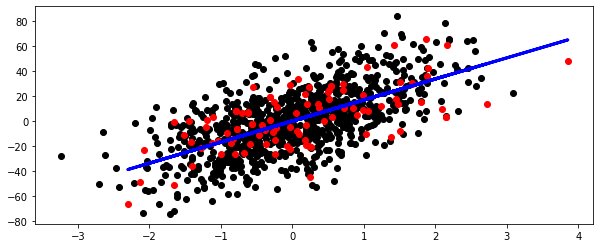

In [40]:
n_samples = 1000
X, y = make_regression(n_samples=n_samples, n_features=1, noise=20, random_state=42)

X_train, X_test, y_train, y_test = get_train_test(X, y)

alphas = np.logspace(-5, -1, 100)
regr = linear_model.RidgeCV(normalize=True, alphas=alphas)  # modèle linéaire avec régularisation Ridge

regr.fit(X_train, y_train)    # entraînement avec les données X_train et les cibles y_train
y_pred = regr.predict(X_test) # prédiction sur les données test

report_regression(X_train, X_test, y_train, y_test, y_pred, regr)

### Régularisation Lasso : recherche du paramètre, avec validation croisée

In [41]:
n_samples = 1000
X, y = make_regression(n_samples=n_samples, n_features=1, noise=20, random_state=42)

X_train, X_test, y_train, y_test = get_train_test(X, y)

alphas = np.logspace(-5, -1, 100)
regr = linear_model.LassoCV(normalize=True, alphas=alphas)  # modèle linéaire avec régularisation Lasso

regr.fit(X_train, y_train)    # entraînement avec les données X_train et les cibles y_train
y_pred = regr.predict(X_test) # prédiction sur les données test

report_regression(X_train, X_test, y_train, y_test, y_pred, regr)

alpha = 1.520e-03, Erreur quadratique: 334.379, Coefficient de détermination: 0.396


### Régularisation ElasticNet : recherche du paramètre, avec validation croisée

In [42]:
n_samples = 1000
X, y = make_regression(n_samples=n_samples, n_features=1, noise=20, random_state=42)

X_train, X_test, y_train, y_test = get_train_test(X, y)

r = np.linspace(0.001, 0.999, 100)
regr = linear_model.ElasticNetCV(normalize=True, l1_ratio=r, n_alphas=10)  # modèle linéaire avec régularisation Ridge

regr.fit(X_train, y_train)    # entraînement avec les données X_train et les cibles y_train
y_pred = regr.predict(X_test) # prédiction sur les données test

report_regression(X_train, X_test, y_train, y_test, y_pred, regr)

alpha = 5.438e-04, l1_ratio = 0.989, Erreur quadratique: 333.853, Coefficient de détermination: 0.397


### Application à un jeu de données : progrès du diabète

In [43]:
from sklearn.datasets import load_diabetes

data = load_diabetes()

X_bmi = data.data[:, np.newaxis, 2]
X_s2 = data.data[:, np.newaxis, 5]
y = data.target 

In [44]:
@interact(k=(0, 9))
def diabetes(k=0):
    X_train, X_test, y_train, y_test = get_train_test(data.data[:, np.newaxis, k], y)

    regr = linear_model.LinearRegression(normalize=True)  # modèle linéaire avec régularisation Ridge

    regr.fit(X_train, y_train)    # entraînement avec les données X_train et les cibles y_train
    y_pred = regr.predict(X_test) # prédiction sur les données test

    report_regression(X_train, X_test, y_train, y_test, y_pred, regr, title=f'{data.feature_names[k]}')

interactive(children=(IntSlider(value=0, description='k', max=9), Output()), _dom_classes=('widget-interact',)…

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

for i, (X, title) in enumerate(zip([X_bmi, X_s2],["bmi", "s2"])):
    X_train, X_test, y_train, y_test = get_train_test(X, y)

    alphas = np.logspace(-4, 0, 21)
    regr = linear_model.RidgeCV(normalize=True, alphas=alphas)  # modèle linéaire avec régularisation Ridge

    regr.fit(X_train, y_train)    # entraînement avec les données X_train et les cibles y_train
    y_pred = regr.predict(X_test) # prédiction sur les données test

    report_regression(X_train, X_test, y_train, y_test, y_pred, regr, ax=ax[i], title=title)

alpha = 3.981e-03, Erreur quadratique: 3718.881, Coefficient de détermination: 0.342
alpha = 1.000e-01, Erreur quadratique: 5318.514, Coefficient de détermination: 0.059


alpha = 1.000e-09, Erreur quadratique: 3717.348, Coefficient de détermination: 0.343
alpha = 1.000e-09, Erreur quadratique: 5296.095, Coefficient de détermination: 0.063


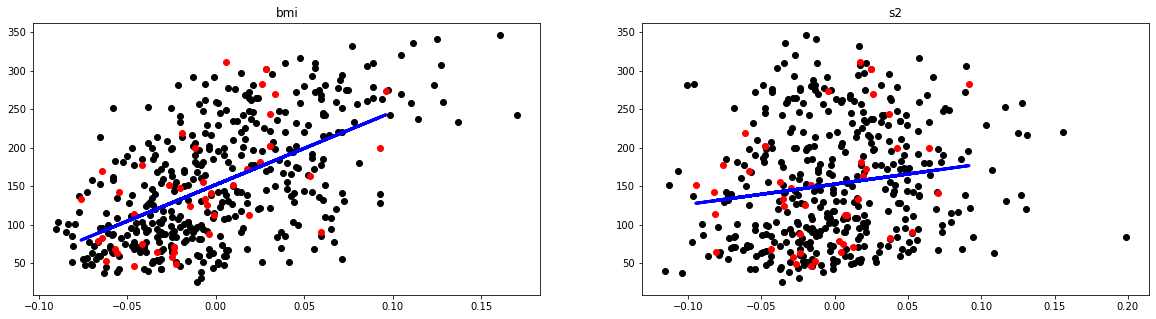

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

for i, (X, title) in enumerate(zip([X_bmi, X_s2],["bmi", "s2"])):
    X_train, X_test, y_train, y_test = get_train_test(X, y)

    alphas = np.logspace(-9, -2, 21)
    regr = linear_model.LassoCV(normalize=True, alphas=alphas)  # modèle linéaire avec régularisation Ridge

    regr.fit(X_train, y_train)    # entraînement avec les données X_train et les cibles y_train
    y_pred = regr.predict(X_test) # prédiction sur les données test

    report_regression(X_train, X_test, y_train, y_test, y_pred, regr, ax=ax[i], title=title)

alpha = 2.273e-03, l1_ratio = 0.999, Erreur quadratique: 3718.079, Coefficient de détermination: 0.342
alpha = 1.005e-03, l1_ratio = 0.626, Erreur quadratique: 5329.271, Coefficient de détermination: 0.057


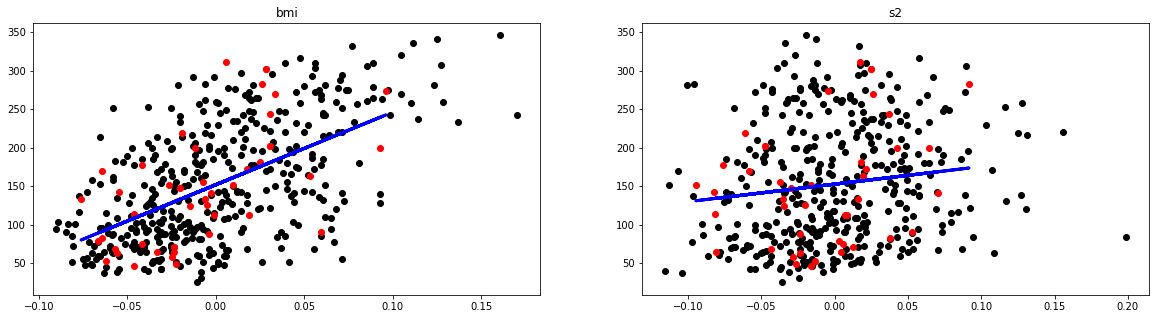

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

for i, (X, title) in enumerate(zip([X_bmi, X_s2],["bmi", "s2"])):
    X_train, X_test, y_train, y_test = get_train_test(X, y)

    r = np.linspace(0.001, 0.999, 100)
    regr = linear_model.ElasticNetCV(normalize=True, l1_ratio=r, n_alphas=10)  # modèle linéaire avec régularisation ElasticNet

    regr.fit(X_train, y_train)    # entraînement avec les données X_train et les cibles y_train
    y_pred = regr.predict(X_test) # prédiction sur les données test

    report_regression(X_train, X_test, y_train, y_test, y_pred, regr, ax=ax[i], title=title)

### Régression avec trois features

In [48]:
for i in [0, 2, 3, 4, 5, 6, 8]:
    for j in [0, 2, 3, 4, 5, 6, 8]:
        if j > i:
            for k in [0, 2, 3, 4, 5, 6, 8]:
                if k > j:
                    X_train, X_test, y_train, y_test = get_train_test(data.data[:, [i, j, k]], y)

                    regr = linear_model.LinearRegression(normalize=True)  # modèle linéaire avec régularisation Ridge

                    regr.fit(X_train, y_train)    # entraînement avec les données X_train et les cibles y_train
                    y_pred = regr.predict(X_test) # prédiction sur les données test

                    if r2_score(y_test, y_pred) > 0.3:
                        report_regression(X_train, X_test, y_train, y_test, y_pred, regr, plot=False, string=f"{data.feature_names[i]}, {data.feature_names[j]}, {data.feature_names[k]} : ")

age, bmi, bp : Erreur quadratique: 3506.305, Coefficient de détermination: 0.380
age, bmi, s1 : Erreur quadratique: 3795.774, Coefficient de détermination: 0.329
age, bmi, s2 : Erreur quadratique: 3870.289, Coefficient de détermination: 0.315
age, bmi, s5 : Erreur quadratique: 3852.031, Coefficient de détermination: 0.319
bmi, bp, s1 : Erreur quadratique: 3426.918, Coefficient de détermination: 0.394
bmi, bp, s2 : Erreur quadratique: 3455.942, Coefficient de détermination: 0.389
bmi, bp, s5 : Erreur quadratique: 3573.961, Coefficient de détermination: 0.368
bmi, s1, s2 : Erreur quadratique: 3532.360, Coefficient de détermination: 0.375
bmi, s2, s5 : Erreur quadratique: 3874.975, Coefficient de détermination: 0.315


### Régression avec trois features : ElsasticNet

In [49]:
for i in [0, 2, 3, 4, 5, 6, 8]:
    for j in [0, 2, 3, 4, 5, 6, 8]:
        if j > i:
            for k in [0, 2, 3, 4, 5, 6, 8]:
                if k > j:
                    X_train, X_test, y_train, y_test = get_train_test(data.data[:, [i, j, k]], y)

                    r = np.linspace(0.001, 0.999, 100)
                    regr = linear_model.ElasticNetCV(normalize=True, l1_ratio=r, n_alphas=10)  # modèle linéaire avec régularisation ElasticNet

                    regr.fit(X_train, y_train)    # entraînement avec les données X_train et les cibles y_train
                    y_pred = regr.predict(X_test) # prédiction sur les données test

                    if r2_score(y_test, y_pred) > 0.3:
                        report_regression(X_train, X_test, y_train, y_test, y_pred, regr, plot=False, string=f"{data.feature_names[i]}, {data.feature_names[j]}, {data.feature_names[k]} : ")

age, bmi, bp : alpha = 4.897e-02, l1_ratio = 0.999, Erreur quadratique: 3507.123, Coefficient de détermination: 0.380
age, bmi, s1 : alpha = 2.320e-03, l1_ratio = 0.979, Erreur quadratique: 3802.908, Coefficient de détermination: 0.327
age, bmi, s2 : alpha = 4.897e-02, l1_ratio = 0.999, Erreur quadratique: 3871.975, Coefficient de détermination: 0.315
age, bmi, s5 : alpha = 1.055e-01, l1_ratio = 0.999, Erreur quadratique: 3831.705, Coefficient de détermination: 0.322
bmi, bp, s1 : alpha = 4.897e-02, l1_ratio = 0.999, Erreur quadratique: 3446.424, Coefficient de détermination: 0.390
bmi, bp, s2 : alpha = 1.055e-01, l1_ratio = 0.999, Erreur quadratique: 3490.749, Coefficient de détermination: 0.383
bmi, bp, s5 : alpha = 2.344e-03, l1_ratio = 0.969, Erreur quadratique: 3573.966, Coefficient de détermination: 0.368
bmi, s1, s2 : alpha = 2.296e-03, l1_ratio = 0.989, Erreur quadratique: 3549.041, Coefficient de détermination: 0.372
bmi, s2, s5 : alpha = 2.296e-03, l1_ratio = 0.989, Erreur qu